In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math 

from numba import jit

In [2]:
@jit(nopython=True, parallel=True)
def Fourier_Transform(values, coor, momentum , patternCos, patternSin, coor_num, momen_num):    
    # c is the coordinate index;  m is the momentum index
    for c in range( momen_num ):
        for m in range(coor_num):
            ## Initialize the variables
            holder = coor[m,0] * momentum[c,0] + coor[m,1] * momentum[c,1] + coor[m,2] * momentum[c,2]
            patternCos[c] +=  values[m]* math.cos(holder)
            patternSin[c] +=  values[m]* math.sin(holder)
    
    return patternCos, patternSin        
    
@jit(nopython=True, parallel=True)
def Target_and_Difference(patternCos, patternSin, measurement, momen_num):

    difference = np.square(patternCos) + np.square(patternSin) - measurement
    loss = np.sum(np.square(difference))
    
    return loss , difference
    
@jit(nopython=True, parallel=True)
def Gradient(difference, patternCos, patternSin, coor, momentum , gradient, coor_num, momen_num):

    gradient_norm = 0
    
    for c in range(coor_num) :
        gradient[c] = 0 # Initialize
        
        for m in range(momen_num):
            holder = 0 # Initialize 
            
            for l in range(3):
                holder += coor[c, l] * momentum[m , l]
                
            gradient[c] += 4*difference[m]* (patternCos[m]*math.cos(holder) +
                                           patternSin[m]*math.cos(holder))
        gradient_norm += gradient[c]**2
    
    return gradient_norm, gradient

# Prepare variables

In [3]:
# Load coordinate, momentum, sample
ground_truth = np.load('./sample.npy')
ground_truth = ground_truth*2 + 1

ground_truth_1d = ground_truth.reshape([-1])
coor_num = ground_truth_1d.shape[0]

coordinate_grid_1d = np.load('./coordinate_grid_flat.npy')

momentum = np.load('./momentum_grid.npy')
momen_num = np.prod(momentum.shape[:-1])
momentum_grid_1d = momentum.reshape([momen_num , 3])

# Create the history array to holds intermidiate results
iter_num = 500
history_guess = np.zeros((iter_num, ground_truth_1d.shape[0]))
history_loss = np.zeros(iter_num)

# Create patternCos, patternSin, gradient, difference, target
patternCos = np.zeros(momen_num)
patternSin = np.zeros_like(patternCos)
gradient = np.zeros(coor_num)
difference = np.zeros(momen_num)

# Calculate the measurement

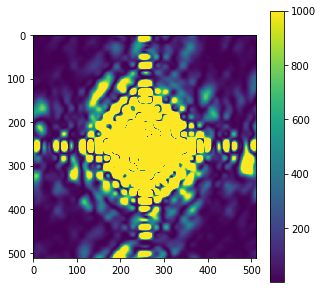

(262144,)


In [6]:
# Calculate the actual diffraction pattern
patternCos, patternSin = Fourier_Transform(ground_truth_1d,
                                           coordinate_grid_1d, 
                                           momentum_grid_1d, 
                                           patternCos,
                                           patternSin,
                                           coor_num,
                                           momen_num)

result = np.square(patternCos) + np.square(patternSin)

result_2d = np.reshape(result, (512,512))

plt.figure(figsize=(5,5))
plt.imshow(result_2d,vmax=1e3)
plt.colorbar()
plt.show()

# Move the measurement to gpu
measurement = np.copy(result)
print measurement.shape

In [7]:
momen

262144